In [1]:
import os
import tempfile

import scanpy as sc
import scvi
import seaborn as sns
import torch
from rich import print
from scib_metrics.benchmark import Benchmarker

/home/data/sdzl14/anaconda3/envs/scvi-env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/data/sdzl14/anaconda3/envs/scvi-env/lib/python3.10/site-packages/docrep/decorators.py:43: SyntaxWarning: 'param_categorical_covariate_keys' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)
/home/data/sdzl14/anaconda3/envs/scvi-env/lib/python3.10/site-packages/docrep/decorators.py:43: SyntaxWarning: 'param_continuous_covariate_keys' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)


In [67]:
adata = sc.read_h5ad('/home/data/sdzl14/NSCLC/zong/stromal.h5ad')
adata = adata.copy()

In [47]:
adata.obs['cell_type']

Peng_Zhang_2024BD_P_P01_N_456288-1            NaN
Peng_Zhang_2024BD_P_P01_N_653646-1            NaN
Peng_Zhang_2024BD_P_P01_N_144641-1            NaN
Peng_Zhang_2024BD_P_P01_N_618629-1            NaN
Peng_Zhang_2024BD_P_P01_N_755123-1            NaN
                                             ... 
Tagore_S_2025_KRAS_13_TTTACTGAGTTACCCA-1-3    NaN
Tagore_S_2025_KRAS_13_TTTACTGCAACGCACC-1-3    NaN
Tagore_S_2025_KRAS_13_TTTACTGCAATCGAAA-1-3    NaN
Tagore_S_2025_KRAS_13_TTTGTCACAGCTCGCA-1-3    NaN
Tagore_S_2025_KRAS_13_TTTGTCATCGGGAGTA-1-3    NaN
Name: cell_type, Length: 78708, dtype: category
Categories (9, object): ['Endothelial cell arterial', 'Endothelial cell capillary', 'Endothelial cell lymphatic', 'Endothelial cell venous', ..., 'Fibroblast alveolar', 'Fibroblast peribronchial', 'Smooth muscle cell', 'stromal dividing']

In [68]:

adata.obs['minor'] = adata.obs['minor'].cat.add_categories('NaN').fillna('NaN')

In [70]:
print(adata.obs['minor'].value_counts())

minor
NaN                61552
MB_NR4A1           10889
MB_TXNIP            6602
AM                  5725
Venule              3426
MB_FCRL4            2336
SMC                 2096
Capillary           2095
COL11A1+ CAF        1945
Pericyte            1773
SELE+ Venule        1617
MYH11+ Pericyte     1536
CPE+ Venule         1425
Tip                 1217
Artery               941
ADH1B+ CAF           777
BCHE+ SMC            234
Lymphatic EC         123
Name: count, dtype: int64

In [69]:
adata.layers['counts'] = adata.X.copy()
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)


In [71]:
sc.pp.highly_variable_genes(
    adata,
    flavor="seurat",
    n_top_genes=2000,
    subset=True,
    inplace=True,batch_key="Dataset")

In [15]:
adata

AnnData object with n_obs × n_vars = 87766 × 2000
    obs: 'Sample', 'Patient', 'Celltype', 'Dataset', 'Platform', 'Pathtype', 'Drug', 'Timepoint', 'Tissue', 'Origin', 'tumor_nontumor_finer', 'minor', 'cell_type', 'celltype_fine'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'log1p', 'hvg'
    layers: 'counts'

In [72]:
print(adata.obs['Dataset'].value_counts())

Dataset
Peng_Zhang_2024                     44757
Tagore_S_2025                       34712
Goveia_Carmeliet_2020                5879
Travaglini_Krasnow_2020              3307
Kim_Lee_2020                         2869
Lambrechts_Thienpont_2018_6149v2     1801
He_Fan_2021                          1780
Lambrechts_Thienpont_2018_6653        908
Maynard_Bivona_2020                   740
Vieira_Teichmann_2019                 247
Lambrechts_Thienpont_2018_6149v1      123
UKIM-V                                117
Laughney_Massague_2020                 57
Name: count, dtype: int64

In [74]:
print(adata.obs['Dataset'].value_counts())

# 将多个数据集名称放入列表中
selected_datasets = ['Goveia_Carmeliet_2020', 'He_Fan_2021', 'Kim_Lee_2020',
       'Lambrechts_Thienpont_2018_6149v1', 'Lambrechts_Thienpont_2018_6149v2',
       'Lambrechts_Thienpont_2018_6653', 
       'Maynard_Bivona_2020', 'Peng_Zhang_2024', 'Tagore_S_2025',
       'Travaglini_Krasnow_2020', 'UKIM-V', 'Vieira_Teichmann_2019']
# 使用单个列表参数调用 isin()
adata = adata[adata.obs['Dataset'].isin(selected_datasets)]

print(adata.obs['Dataset'].value_counts())

Dataset
Peng_Zhang_2024                     44757
Tagore_S_2025                       34712
Goveia_Carmeliet_2020                5879
Travaglini_Krasnow_2020              3307
Kim_Lee_2020                         2869
Lambrechts_Thienpont_2018_6149v2     1801
He_Fan_2021                          1780
Lambrechts_Thienpont_2018_6653        908
Maynard_Bivona_2020                   740
Vieira_Teichmann_2019                 247
Lambrechts_Thienpont_2018_6149v1      123
UKIM-V                                117
Laughney_Massague_2020                 57
Name: count, dtype: int64

Dataset
Peng_Zhang_2024                     44757
Tagore_S_2025                       34712
Goveia_Carmeliet_2020                5879
Travaglini_Krasnow_2020              3307
Kim_Lee_2020                         2869
Lambrechts_Thienpont_2018_6149v2     1801
He_Fan_2021                          1780
Lambrechts_Thienpont_2018_6653        908
Maynard_Bivona_2020                   740
Vieira_Teichmann_2019                 247
Lambrechts_Thienpont_2018_6149v1      123
UKIM-V                                117
Name: count, dtype: int64

In [75]:
adata = adata.copy()
scvi.model.SCVI.setup_anndata(adata,  batch_key="Dataset",layer='counts')

In [76]:
model = scvi.model.SCVI(adata, n_layers=3, n_latent=40, gene_likelihood="nb",dispersion='gene-batch')

In [77]:
model.train(max_epochs=100,batch_size=128)

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/data/sdzl14/anaconda3/envs/scvi-env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=151` in the `DataLoader` to improve performance.


Epoch 100/100: 100%|██████████| 100/100 [13:58<00:00,  7.40s/it, v_num=1, train_loss_step=691, train_loss_epoch=644]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|██████████| 100/100 [13:58<00:00,  8.39s/it, v_num=1, train_loss_step=691, train_loss_epoch=644]


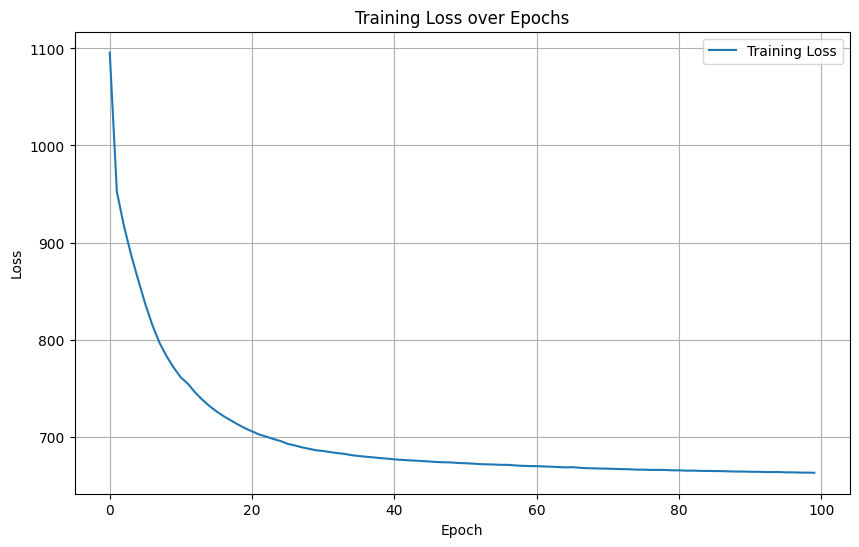

In [78]:
# 获取损失值
losses = model.history_['elbo_train']
import matplotlib.pyplot as plt
# 绘制损失值随 epoch 变化的图像
plt.figure(figsize=(10, 6))
plt.plot(losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [79]:
SCVI_LATENT_KEY = "X_scVI"
adata.obsm[SCVI_LATENT_KEY] = model.get_latent_representation()

In [ ]:
scanvi_model = scvi.model.SCANVI.from_scvi_model(
    model,
    adata=adata,
    labels_key="minor",
    unlabeled_category="NaN"
    
)

In [28]:
scanvi_model.train(max_epochs=100, batch_size=128)

INFO     Training for 100 epochs.                                                                                  


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/data/sdzl14/anaconda3/envs/scvi-env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=151` in the `DataLoader` to improve performance.


Epoch 100/100: 100%|██████████| 100/100 [26:08<00:00, 16.71s/it, v_num=1, train_loss_step=510, train_loss_epoch=622]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|██████████| 100/100 [26:08<00:00, 15.69s/it, v_num=1, train_loss_step=510, train_loss_epoch=622]


In [29]:
SCANVI_LATENT_KEY = "X_scANVI"
adata.obsm[SCANVI_LATENT_KEY] = scanvi_model.get_latent_representation(adata)

In [30]:
adata

AnnData object with n_obs × n_vars = 78708 × 2000
    obs: 'Sample', 'Patient', 'Celltype', 'Dataset', 'Platform', 'Pathtype', 'Drug', 'Timepoint', 'Tissue', 'Origin', 'tumor_nontumor_finer', 'minor', 'cell_type', 'celltype_fine', '_scvi_batch', '_scvi_labels'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'log1p', 'hvg', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'X_scVI', 'X_scANVI'
    layers: 'counts'

In [53]:
sc.pp.neighbors(adata, use_rep=SCANVI_LATENT_KEY)
sc.tl.umap(adata, min_dist=0.1)

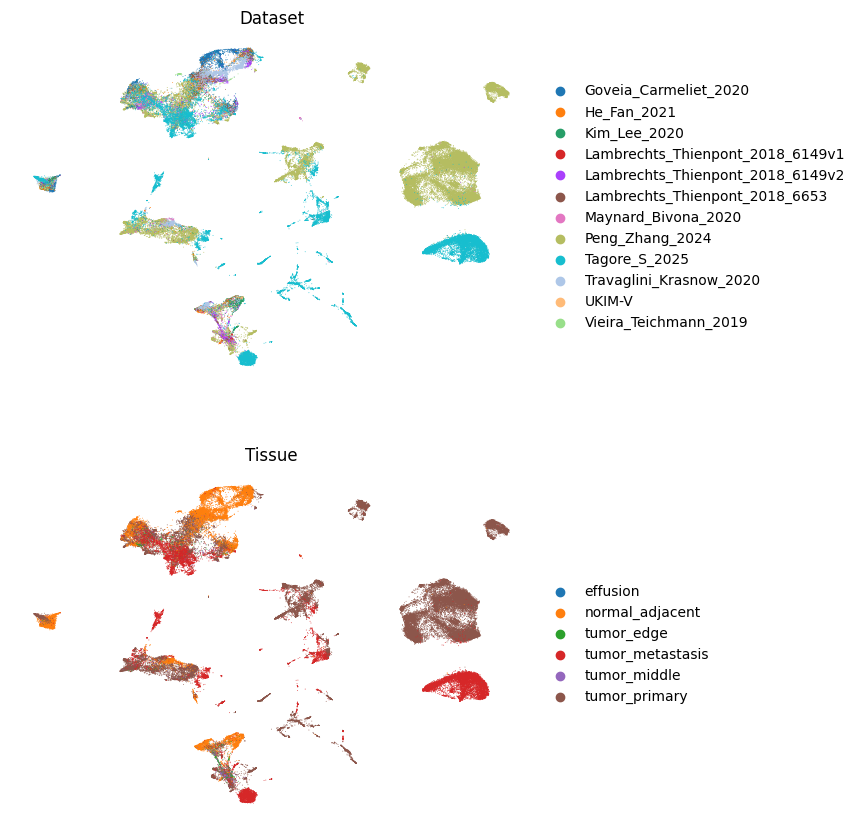

In [54]:
sc.pl.umap(
    adata,
    color=["Dataset",'Tissue'],
    frameon=False,
    ncols=1,
)

In [80]:
model_fix_linear = scvi.model.SCANVI.from_scvi_model(
    model,
    adata=adata,
    labels_key="minor",
    unlabeled_category="NaN",
    linear_classifier=True,
)
model_fix_linear.train(max_epochs=100, check_val_every_n_epoch=1)

INFO     Training for 100 epochs.                                                                                  


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/data/sdzl14/anaconda3/envs/scvi-env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=151` in the `DataLoader` to improve performance.
/home/data/sdzl14/anaconda3/envs/scvi-env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing 

Epoch 100/100: 100%|██████████| 100/100 [34:49<00:00, 20.74s/it, v_num=1, train_loss_step=668, train_loss_epoch=646]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|██████████| 100/100 [34:49<00:00, 20.89s/it, v_num=1, train_loss_step=668, train_loss_epoch=646]


In [81]:
model_fix = scvi.model.SCANVI.from_scvi_model(
    model,
    adata=adata,
    labels_key="minor",
    unlabeled_category="NaN",
)
model_fix.train(max_epochs=100, check_val_every_n_epoch=1)

INFO     Training for 100 epochs.                                                                                  


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/data/sdzl14/anaconda3/envs/scvi-env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=151` in the `DataLoader` to improve performance.
/home/data/sdzl14/anaconda3/envs/scvi-env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing 

Epoch 100/100: 100%|██████████| 100/100 [37:24<00:00, 23.57s/it, v_num=1, train_loss_step=561, train_loss_epoch=645]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|██████████| 100/100 [37:24<00:00, 22.44s/it, v_num=1, train_loss_step=561, train_loss_epoch=645]


In [82]:
model_no_fix = scvi.model.SCANVI.from_scvi_model(
    model,
    adata=adata,
    labels_key="minor",
    unlabeled_category="NaN",
    classifier_parameters={"logits": False},
)
model_no_fix.train(max_epochs=100, check_val_every_n_epoch=1,early_stopping=True,early_stopping_patience=10)

INFO     Training for 100 epochs.                                                                                  


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/data/sdzl14/anaconda3/envs/scvi-env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=151` in the `DataLoader` to improve performance.
/home/data/sdzl14/anaconda3/envs/scvi-env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing 

Epoch 100/100: 100%|██████████| 100/100 [44:02<00:00, 28.95s/it, v_num=1, train_loss_step=687, train_loss_epoch=746]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|██████████| 100/100 [44:02<00:00, 26.43s/it, v_num=1, train_loss_step=687, train_loss_epoch=746]


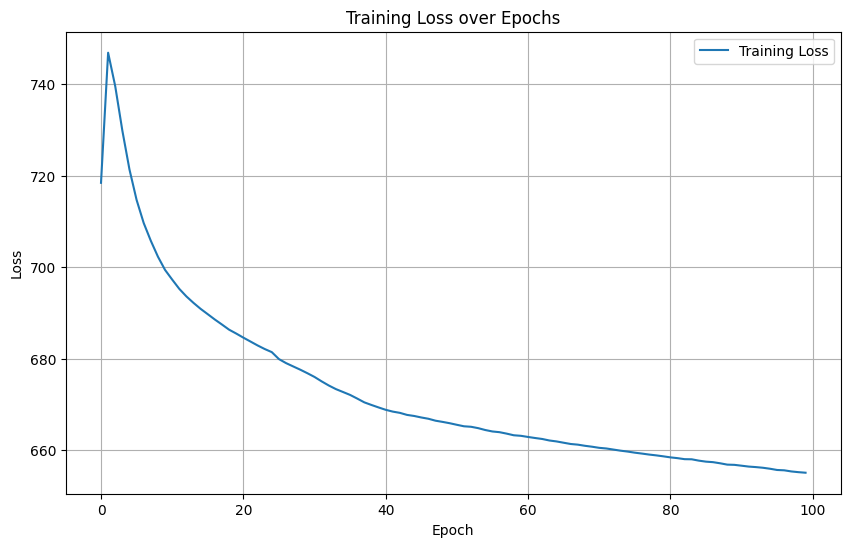

In [59]:
# 获取损失值
losses = model_no_fix.history_['elbo_train']
import matplotlib.pyplot as plt
# 绘制损失值随 epoch 变化的图像
plt.figure(figsize=(10, 6))
plt.plot(losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [83]:
import matplotlib.pyplot as plt
def plot_classification_metrics(
    model_no_fix: scvi.model.SCANVI,
    model_fix: scvi.model.SCANVI,
    model_fix_linear: scvi.model.SCANVI,
):
    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10.5, 7), sharey=False, sharex=True)

    def plot_metric(ax, metric, model, title, ylim, lw=1.25):
        ax.plot(
            model.history[f"train_{metric}"],
            label="train",
            color="darkgreen",
            linewidth=lw,
        )
        ax.plot(
            model.history[f"validation_{metric}"],
            label="validation",
            color="firebrick",
            linewidth=lw,
        )
        ax.set_ylim(ylim)
        ax.legend()
        ax.set_title(title)

    metrics = ["classification_loss", "calibration_error", "accuracy"]
    ylims = [(-0.1, 2.3), (-0.01, 0.18), (0.8, 1.0)]
    models = [model_no_fix, model_fix, model_fix_linear]
    model_names = ["No fix", "Fix", "Fix linear"]

    for i, (metric, ylim) in enumerate(zip(metrics, ylims, strict=False)):
        for j, (model, model_name) in enumerate(zip(models, model_names, strict=False)):
            plot_metric(axes[i, j], metric, model, model_name, ylim=ylim)

    fig.text(-0.01, 0.8, "Classification loss", va="center", rotation="vertical")
    fig.text(-0.01, 0.5, "Calibration error", va="center", rotation="vertical")
    fig.text(-0.01, 0.2, "Accuracy", va="center", rotation="vertical")
    fig.text(0.5, -0.01, "Epoch", ha="center")
    fig.tight_layout()

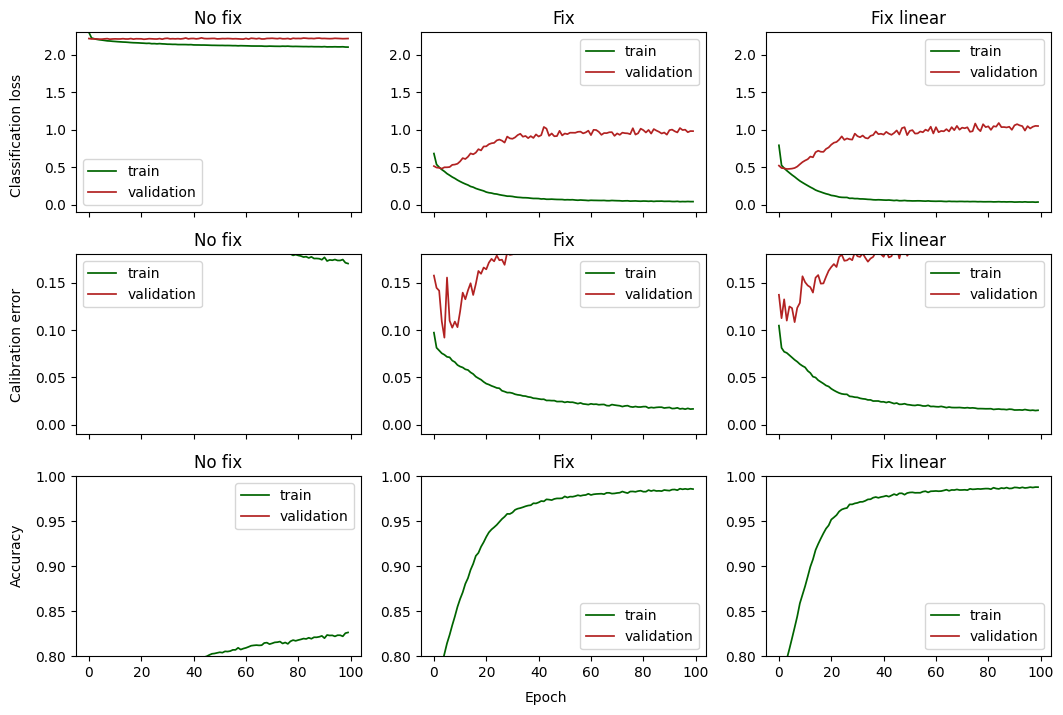

In [84]:
plot_classification_metrics(model_no_fix, model_fix, model_fix_linear)

In [85]:
import numpy as np
def plot_confusion_matrices(
    model_no_fix: scvi.model.SCANVI,
    model_fix: scvi.model.SCANVI,
    model_fix_linear: scvi.model.SCANVI,
    subset: str | None = None,
    prediction_key: str = "_prediction",
    labels_key: str = "minor",
):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6.375), sharey=False, sharex=False)

    def plot_confusion_matrix(ax, model, title, subset):
        adata = model.adata
        adata.obs[prediction_key] = model.predict()

        if subset == "validation":
            adata = adata[model.validation_indices].copy()
        elif subset == "train":
            adata = adata[model.train_indices].copy()

        df = adata.obs.groupby([labels_key, prediction_key]).size().unstack(fill_value=0)
        conf_mat = df / df.sum(axis=1).values[:, np.newaxis]

        _ = ax.pcolor(conf_mat, cmap="cividis", vmin=0, vmax=1)
        _ = ax.set_xticks(np.arange(0.5, len(df.columns), 1), df.columns, rotation=90)
        _ = ax.set_yticks(np.arange(0.5, len(df.index), 1), df.index)
        ax.set_title(title)

    models = [model_no_fix, model_fix, model_fix_linear]
    model_names = ["No fix", "Fix", "Fix linear"]

    for model, model_name, ax in zip(models, model_names, axes, strict=False):
        plot_confusion_matrix(ax, model, model_name, subset)

    fig.text(0.0, 0.5, "Observed", va="center", rotation="vertical")
    fig.text(0.5, 0.0, "Predicted", ha="center")
    fig.tight_layout()

/tmp/ipykernel_2317077/3373622046.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df = adata.obs.groupby([labels_key, prediction_key]).size().unstack(fill_value=0)
/tmp/ipykernel_2317077/3373622046.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df = adata.obs.groupby([labels_key, prediction_key]).size().unstack(fill_value=0)
/tmp/ipykernel_2317077/3373622046.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
 

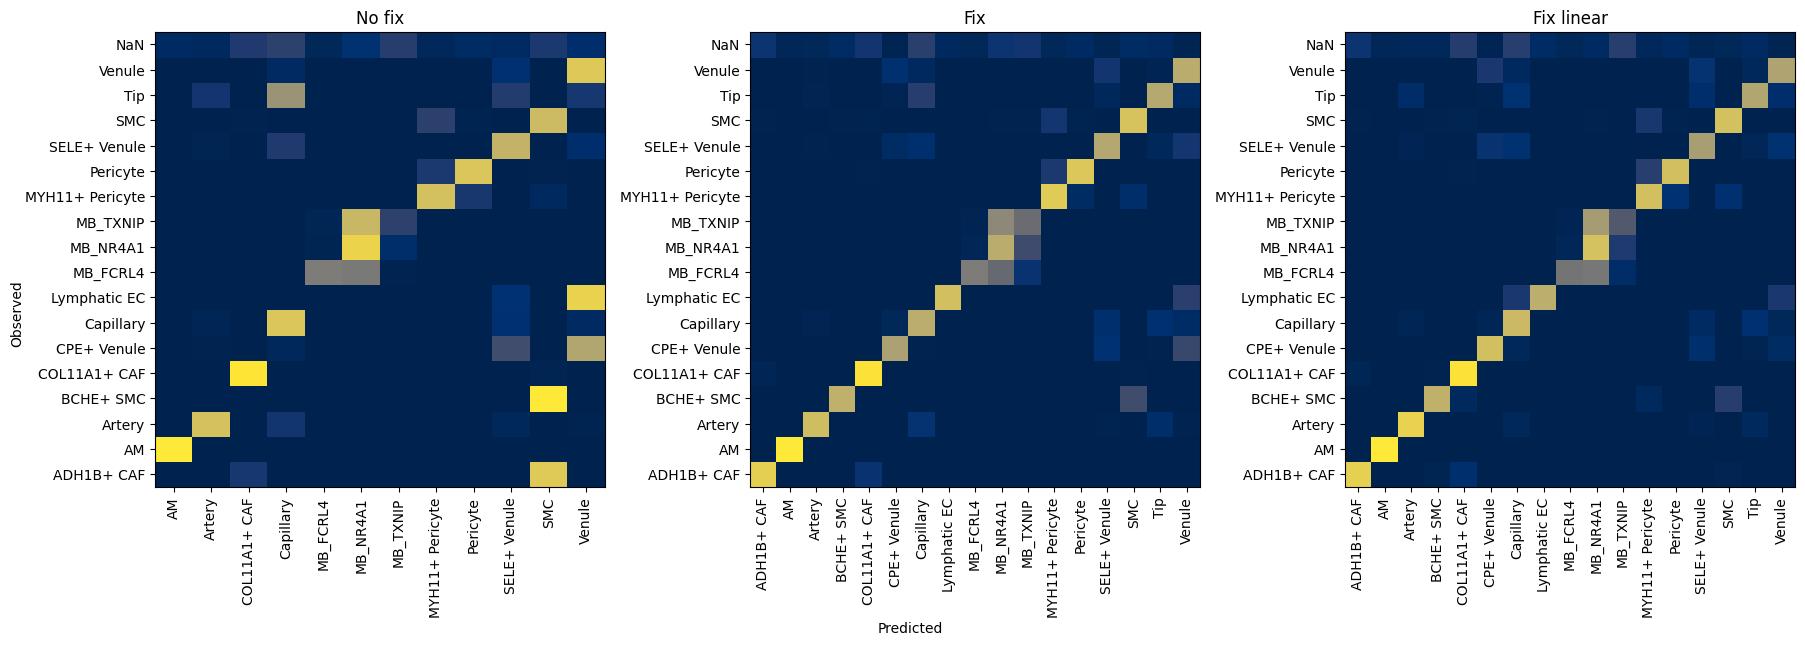

In [86]:
plot_confusion_matrices(model_no_fix, model_fix, model_fix_linear, subset="validation")

In [87]:
def plot_latent_umaps(
    model_no_fix: scvi.model.SCANVI,
    model_fix: scvi.model.SCANVI,
    model_fix_linear: scvi.model.SCANVI,
    color: list | str | None = None,
    subset: str | None = None,
    latent_key: str = "_latent",
):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(11, 3), sharey=False, sharex=False)

    def plot_latent_umap(ax, model, title, subset, legend_loc):
        adata = model.adata
        adata.obsm[latent_key] = model.get_latent_representation()
        sc.pp.neighbors(adata, use_rep=latent_key)

        if subset == "validation":
            adata = model.adata[model.validation_indices].copy()
        elif subset == "train":
            adata = model.adata[model.train_indices].copy()

        sc.tl.umap(adata, min_dist=0.3)
        sc.pl.umap(
            adata,
            color=color,
            frameon=False,
            ncols=1,
            ax=ax,
            show=False,
            legend_loc=legend_loc,
        )
        ax.set_title(title)

    models = [model_no_fix, model_fix, model_fix_linear]
    model_names = ["No fix", "Fix", "Fix linear"]
    legend_loc = ["none", "none", "right margin"]

    for model, model_name, ax, leg_loc in zip(models, model_names, axes, legend_loc, strict=False):
        plot_latent_umap(ax, model, model_name, subset, leg_loc)

    fig.text(0.0, 0.5, "UMAP_2", va="center", rotation="vertical")
    fig.text(0.5, 0.0, "UMAP_1", ha="center")
    fig.tight_layout()

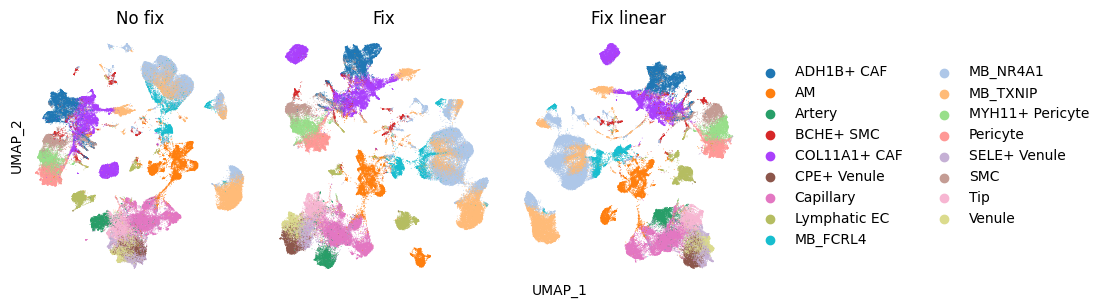

In [88]:
plot_latent_umaps(model_no_fix, model_fix, model_fix_linear, color="_prediction")

In [89]:
X_SCVI_KEY = "X_scvi"
X_SCANVI_NO_FIX_KEY = "X_scanvi_no_fix"
X_SCANVI_FIX_KEY = "X_scanvi_fix"
X_SCANVI_FIX_LINEAR_KEY = "X_scanvi_fix_linear"

adata.obsm[X_SCVI_KEY] = model.get_latent_representation()
adata.obsm[X_SCANVI_NO_FIX_KEY] = model_no_fix.get_latent_representation()
adata.obsm[X_SCANVI_FIX_KEY] = model_fix.get_latent_representation()
adata.obsm[X_SCANVI_FIX_LINEAR_KEY] = model_fix_linear.get_latent_representation()

In [90]:
adata.write_h5ad('/home/data/sdzl14/NSCLC/zong/stromal.scanvi.h5ad')

Dataset
Peng_Zhang_2024                     44757
Tagore_S_2025                       34712
Goveia_Carmeliet_2020                5879
Travaglini_Krasnow_2020              3307
Kim_Lee_2020                         2869
Lambrechts_Thienpont_2018_6149v2     1801
He_Fan_2021                          1780
Lambrechts_Thienpont_2018_6653        908
Maynard_Bivona_2020                   740
Vieira_Teichmann_2019                 247
Lambrechts_Thienpont_2018_6149v1      123
UKIM-V                                117
Name: count, dtype: int64

Dataset
Peng_Zhang_2024                     44757
Tagore_S_2025                       34712
Goveia_Carmeliet_2020                5879
Travaglini_Krasnow_2020              3307
Kim_Lee_2020                         2869
Lambrechts_Thienpont_2018_6149v2     1801
He_Fan_2021                          1780
Lambrechts_Thienpont_2018_6653        908
Maynard_Bivona_2020                   740
Vieira_Teichmann_2019                 247
Lambrechts_Thienpont_2018_6149v1      123
UKIM-V                                117
Laughney_Massague_2020                 57
Name: count, dtype: int64

Dataset
Peng_Zhang_2024                     44757
Tagore_S_2025                       34712
Goveia_Carmeliet_2020                5879
Travaglini_Krasnow_2020              3307
Kim_Lee_2020                         2869
Lambrechts_Thienpont_2018_6149v2     1801
He_Fan_2021                          1780
Lambrechts_Thienpont_2018_6653        908
Maynard_Bivona_2020                   740
Vieira_Teichmann_2019                 247
Lambrechts_Thienpont_2018_6149v1      123
UKIM-V                                117
Name: count, dtype: int64

/tmp/ipykernel_2444921/4005602447.py:16: ImplicitModificationWarning: Setting element `.layers['counts']` of view, initializing view as actual.
  stromal.layers['counts'] = stromal.X.copy()


_prediction
MB_NR4A1           16056
MB_TXNIP           12903
Capillary          10474
COL11A1+ CAF        9704
AM                  7062
ADH1B+ CAF          6181
Pericyte            4099
Tip                 3777
Venule              3570
MB_FCRL4            3509
MYH11+ Pericyte     3480
SMC                 3390
Lymphatic EC        3212
SELE+ Venule        2900
Artery              2702
CPE+ Venule         2546
BCHE+ SMC           1675
Name: count, dtype: int64

_scvi_batch
7     44757
8     34712
0      5879
9      3307
2      2869
4      1801
1      1780
5       908
6       740
11      247
3       123
10      117
Name: count, dtype: int64

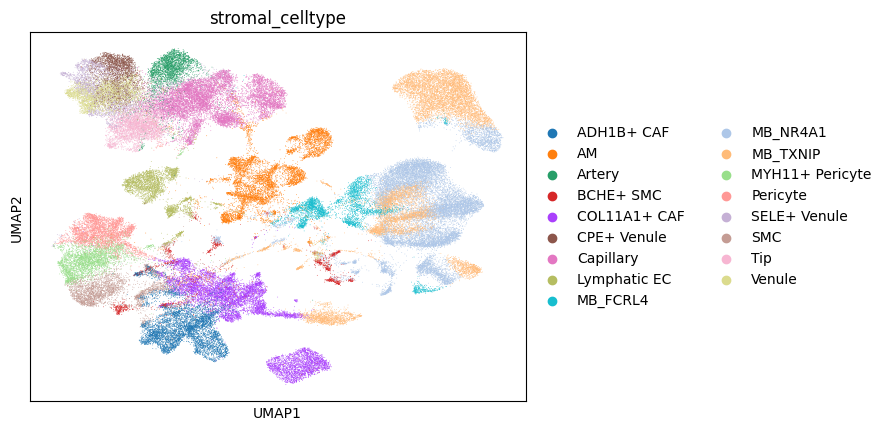

NameError: name 'plt' is not defined

In [2]:
stromal_scanvi = sc.read_h5ad('/home/data/sdzl14/NSCLC/zong/stromal.scanvi.h5ad')
stromal_scanvi = stromal_scanvi.copy()
stromal = sc.read_h5ad("/home/data/sdzl14/NSCLC/zong/stromal.h5ad")
stromal = stromal.copy()
print(stromal_scanvi.obs['Dataset'].value_counts())
print(stromal.obs['Dataset'].value_counts())
# 将多个数据集名称放入列表中
selected_datasets = ['Goveia_Carmeliet_2020', 'He_Fan_2021', 'Kim_Lee_2020',
       'Lambrechts_Thienpont_2018_6149v1', 'Lambrechts_Thienpont_2018_6149v2',
       'Lambrechts_Thienpont_2018_6653', 
       'Maynard_Bivona_2020', 'Peng_Zhang_2024', 'Tagore_S_2025',
       'Travaglini_Krasnow_2020', 'UKIM-V', 'Vieira_Teichmann_2019']
stromal = stromal[stromal.obs['Dataset'].isin(selected_datasets)]

print(stromal.obs['Dataset'].value_counts())
stromal.layers['counts'] = stromal.X.copy()

stromal.obsm['X_scanvi_fix'] = stromal_scanvi.obsm['X_scanvi_fix'].copy()
stromal.obsm['X_scanvi_fix_linear'] = stromal_scanvi.obsm['X_scanvi_fix_linear'].copy()
stromal.obsm['X_scanvi_no_fix'] = stromal_scanvi.obsm['X_scanvi_no_fix'].copy()
stromal.obsm['X_scvi'] = stromal_scanvi.obsm['X_scvi'].copy()
stromal.obsm['X_umap'] = stromal_scanvi.obsm['X_umap'].copy()
stromal.obsm['_latent'] = stromal_scanvi.obsm['_latent'].copy()
print(stromal_scanvi.obs['_prediction'].value_counts())
print(stromal_scanvi.obs['_scvi_batch'].value_counts())
stromal.obs['stromal_celltype'] = stromal_scanvi.obs['_prediction'].copy()
sc.pp.normalize_total(stromal, target_sum=1e4)
sc.pp.log1p(stromal)
sc.pp.highly_variable_genes(
    stromal,
    flavor="seurat",
    n_top_genes=2000,

    inplace=True,batch_key="Dataset")

sc.pp.scale(stromal, max_value=10)
sc.pp.neighbors(stromal, use_rep='X_scanvi_fix_linear',n_neighbors=35)
sc.tl.umap(stromal,min_dist=0.5)
sc.pl.umap(stromal,color=['stromal_celltype'])
plt.savefig('/home/data/sdzl14/NSCLC/zong/fig/stromal/stromal_celltype.png',dpi = 300, bbox_inches='tight')
plt.savefig('/home/data/sdzl14/NSCLC/zong/fig/stromal/stromal_celltype.pdf',dpi = 300, bbox_inches='tight')

In [3]:
stromal

AnnData object with n_obs × n_vars = 97240 × 17317
    obs: 'Sample', 'Patient', 'Celltype', 'Dataset', 'Platform', 'Pathtype', 'Drug', 'Timepoint', 'Tissue', 'Origin', 'tumor_nontumor_finer', 'minor', 'cell_type', 'celltype_fine', 'stromal_celltype'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'mean', 'std'
    uns: 'log1p', 'hvg', 'neighbors', 'umap', 'stromal_celltype_colors'
    obsm: 'X_scanvi_fix', 'X_scanvi_fix_linear', 'X_scanvi_no_fix', 'X_scvi', 'X_umap', '_latent'
    layers: 'counts'
    obsp: 'distances', 'connectivities'